In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import (r2_score,mean_absolute_error,mean_squared_error, make_scorer)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, HalvingGridSearchCV

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE 
from sklearn.impute import SimpleImputer

import re
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [6]:
df = pd.read_csv('/Users/agagoks/Documents/Dibimbing/Projects/Uber Price Prediction/Dataset/rideshare_uberlyft.csv')

In [7]:
df.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

In [8]:
#Initial temporary
#df = df.sample(frac=0.5).reset_index(drop='True')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

# EDA

## Descriptive Statistic

In [10]:
# Drop `CustomerID` since it unnecessary
df = df.drop('id', axis=1)

In [11]:
numericals = df.select_dtypes(include=['int64','float64']).columns.tolist()
categoricals = df.select_dtypes(exclude=['int64','float64']).columns.tolist()

print(f"numericals columns are {numericals}")
print(f"categoricals columns are {categoricals}")

numericals columns are ['timestamp', 'hour', 'day', 'month', 'price', 'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature', 'apparentTemperature', 'precipIntensity', 'precipProbability', 'humidity', 'windSpeed', 'windGust', 'windGustTime', 'visibility', 'temperatureHigh', 'temperatureHighTime', 'temperatureLow', 'temperatureLowTime', 'apparentTemperatureHigh', 'apparentTemperatureHighTime', 'apparentTemperatureLow', 'apparentTemperatureLowTime', 'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex', 'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase', 'precipIntensityMax', 'uvIndexTime', 'temperatureMin', 'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime', 'apparentTemperatureMin', 'apparentTemperatureMinTime', 'apparentTemperatureMax', 'apparentTemperatureMaxTime']
categoricals columns are ['datetime', 'timezone', 'source', 'destination', 'cab_type', 'product_id', 'name', 'short_summary', 'long_summary', 'icon']


In [12]:
df[numericals].describe()

,timestamp,hour,day,month,price,distance,surge_multiplier,latitude,longitude,temperature,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
count,6.930710e+05,693071.000000,693071.000000,693071.000000,637976.000000,693071.000000,693071.000000,693071.000000,693071.000000,693071.000000,...,693071.000000,6.930710e+05,693071.000000,6.930710e+05,693071.000000,6.930710e+05,693071.000000,6.930710e+05,693071.000000,6.930710e+05
mean,1.544046e+09,11.619137,17.794365,11.586684,16.545125,2.189430,1.013870,42.338172,-71.066151,39.584388,...,0.037374,1.544044e+09,33.457774,1.544042e+09,45.261313,1.544047e+09,29.731002,1.544048e+09,41.997343,1.544048e+09
std,6.891925e+05,6.948114,9.982286,0.492429,9.324359,1.138937,0.091641,0.047840,0.020302,6.726084,...,0.055214,6.912028e+05,6.467224,6.901954e+05,5.645046,6.901353e+05,7.110494,6.871862e+05,6.936841,6.910777e+05
min,1.543204e+09,0.000000,1.000000,11.000000,2.500000,0.020000,1.000000,42.214800,-71.105400,18.910000,...,0.000000,1.543162e+09,15.630000,1.543122e+09,33.510000,1.543154e+09,11.810000,1.543136e+09,28.950000,1.543187e+09
25%,1.543444e+09,6.000000,13.000000,11.000000,9.000000,1.280000,1.000000,42.350300,-71.081000,36.450000,...,0.000000,1.543421e+09,30.170000,1.543399e+09,42.570000,1.543439e+09,27.760000,1.543399e+09,36.570000,1.543439e+09
50%,1.543737e+09,12.000000,17.000000,12.000000,13.500000,2.160000,1.000000,42.351900,-71.063100,40.490000,...,0.000400,1.543770e+09,34.240000,1.543727e+09,44.680000,1.543788e+09,30.130000,1.543745e+09,40.950000,1.543788e+09
75%,1.544828e+09,18.000000,28.000000,12.000000,22.500000,2.920000,1.000000,42.364700,-71.054200,43.580000,...,0.091600,1.544807e+09,38.880000,1.544789e+09,46.910000,1.544814e+09,35.710000,1.544789e+09,44.120000,1.544818e+09
max,1.545161e+09,23.000000,30.000000,12.000000,97.500000,7.860000,3.000000,42.366100,-71.033000,57.220000,...,0.145900,1.545152e+09,43.100000,1.545192e+09,57.870000,1.545109e+09,40.050000,1.545134e+09,57.200000,1.545109e+09


In [13]:
df[categoricals].describe()

,datetime,timezone,source,destination,cab_type,product_id,name,short_summary,long_summary,icon
count,693071,693071,693071,693071,693071,693071,693071,693071,693071,693071
unique,31350,1,12,12,2,13,13,9,11,7
top,2018-11-26 23:21:14,America/New_York,Financial District,Financial District,Uber,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,Overcast,Mostly cloudy throughout the day.,cloudy
freq,156,693071,58857,58851,385663,55096,55096,218895,202340,218895


In [14]:
# adjust the figure size for better readability
plt.figure(figsize=(15, 10))

# plotting
features = numericals
num_features = len(features)

# calculate number of rows and columns needed
num_rows = int(np.ceil(num_features / 8))  # 3 plots per row
num_cols = min(num_features, 8)

# create subplots grid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# plot each feature in a separate subplot
for i, feature in enumerate(features):
    row_idx = i // num_cols
    col_idx = i % num_cols
    sns.boxplot(y=df[feature], color='red', ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(feature)

plt.tight_layout()

<Figure size 1500x1000 with 0 Axes>

There are some extreme outliers which are `surge_multiplier`, `precipIntensitiy`, `precipProbability`, `uvIndex`, meanwhile others have common outliers case

In [15]:
plt.figure(figsize=(15, 10))

features = numericals

num_features = len(numericals)
num_rows = int(np.ceil(num_features / 4))  # 3 plots per row
num_cols = min(num_features, 4)

# Create the subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(24, 30))

# Flatten the axs array to make it easier to iterate over the subplots
axs = axs.flatten()

# Iterate over the features and create the subplots
for i, feature in enumerate(numericals):
    sns.kdeplot(x=df[feature], color='skyblue', ax=axs[i])
    axs[i].set_xlabel(feature)

# Remove any extra subplots
for i in range(num_features, num_rows*num_cols):
    fig.delaxes(axs[i])

plt.tight_layout()

<Figure size 1500x1000 with 0 Axes>

## Checking Missing Value

In [16]:
print(df.isna().sum())
print(f'There is {sum(df.isna().sum())} missing values')
print(f'There is {df.duplicated().sum()} duplicated values')

print(f'So it will have {((sum(df.isna().sum()))/(len(df.index))):.2%} of missing values from data')
print(f'So it will have {(df.duplicated().sum()/(len(df.index))):.2%} of duplicated values from data')

timestamp                          0
hour                               0
day                                0
month                              0
datetime                           0
timezone                           0
source                             0
destination                        0
cab_type                           0
product_id                         0
name                               0
price                          55095
distance                           0
surge_multiplier                   0
latitude                           0
longitude                          0
temperature                        0
apparentTemperature                0
short_summary                      0
long_summary                       0
precipIntensity                    0
precipProbability                  0
humidity                           0
windSpeed                          0
windGust                           0
windGustTime                       0
visibility                         0
t

Because it has >5%, therefore I need to impute the missing value

In [17]:
# Drop Duplicated
df.drop_duplicates(inplace=True)

In [18]:
# Median Imputation
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(df[['price']])
df['price'] = imputer.transform(df[['price']])
df

,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,product_id,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,lyft_line,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,lyft_premier,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,lyft_luxsuv,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,lyft_plus,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693066,1.543708e+09,23,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,...,0.0000,1543683600,31.42,1543658400,44.76,1543690800,27.77,1543658400,44.09,1543690800
693067,1.543708e+09,23,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,55c66225-fbe7-4fd5-9072-eab1ece5e23e,...,0.0000,1543683600,31.42,1543658400,44.76,1543690800,27.77,1543658400,44.09,1543690800
693068,1.543708e+09,23,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,...,0.0000,1543683600,31.42,1543658400,44.76,1543690800,27.77,1543658400,44.09,1543690800
693069,1.543708e+09,23,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,...,0.0000,1543683600,31.42,1543658400,44.76,1543690800,27.77,1543658400,44.09,1543690800


In [19]:
print(f'There is {sum(df.isna().sum())} missing values')
print(f'There is {df.duplicated().sum()} duplicated values')

print(f'So it will have {((sum(df.isna().sum()))/(len(df.index))):.2%} of missing values from data')
print(f'So it will have {(df.duplicated().sum()/(len(df.index))):.2%} of duplicated values from data')

There is 0 missing values
There is 0 duplicated values
So it will have 0.00% of missing values from data
So it will have 0.00% of duplicated values from data


In [20]:
df.head(1).T

,0
timestamp,1544952607.89
hour,9
day,16
month,12
datetime,2018-12-16 09:30:07
timezone,America/New_York
source,Haymarket Square
destination,North Station
cab_type,Lyft
product_id,lyft_line


# Processing

In [21]:
df_model = df.copy()

In [22]:
# Extract Minutes & Seconds
df_model['month'] = pd.to_datetime(df_model['datetime']).dt.month
df_model['week'] = pd.to_datetime(df_model['datetime']).dt.week
df_model['day'] = pd.to_datetime(df_model['datetime']).dt.day
df_model['hour'] = pd.to_datetime(df_model['datetime']).dt.hour
df_model['minutes'] = pd.to_datetime(df_model['datetime']).dt.minute
df_model['seconds'] = pd.to_datetime(df_model['datetime']).dt.second

In [23]:
# Drop datetime, timezone (only 1 data), timestamp (similar to datetime)
df_model = df_model.drop(['datetime', 'timezone', 'timestamp'], axis=1)

In [24]:
# Create object
mask = df_model.dtypes == object
categorical_cols = df_model.columns[mask]
print(categorical_cols)

Index(['source', 'destination', 'cab_type', 'product_id', 'name',
       'short_summary', 'long_summary', 'icon'],
      dtype='object')


In [25]:
for col in categorical_cols:
    uniq = df_model[col].unique()
    print(f"Unique values in {col}: {uniq}")

Unique values in source: ['Haymarket Square' 'Back Bay' 'North End' 'North Station' 'Beacon Hill'
 'Boston University' 'Fenway' 'South Station' 'Theatre District'
 'West End' 'Financial District' 'Northeastern University']
Unique values in destination: ['North Station' 'Northeastern University' 'West End' 'Haymarket Square'
 'South Station' 'Fenway' 'Theatre District' 'Beacon Hill' 'Back Bay'
 'North End' 'Financial District' 'Boston University']
Unique values in cab_type: ['Lyft' 'Uber']
Unique values in product_id: ['lyft_line' 'lyft_premier' 'lyft' 'lyft_luxsuv' 'lyft_plus' 'lyft_lux'
 '6f72dfc5-27f1-42e8-84db-ccc7a75f6969'
 '6c84fd89-3f11-4782-9b50-97c468b19529'
 '55c66225-fbe7-4fd5-9072-eab1ece5e23e'
 '9a0e7b09-b92b-4c41-9779-2ad22b4d779d'
 '6d318bcc-22a3-4af6-bddd-b409bfce1546'
 '997acbb5-e102-41e1-b155-9df7de0a73f2'
 '8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a']
Unique values in name: ['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black' 'UberXL'
 'Black' 'UberX' 'WAV' 'Black SU

Without additional information or context, it's difficult to determine the exact nature or purpose of these unique identifiers that could represent specific promotions, experimental services, or internal categorizations within the Uber/Lyft system

## Label Encoding & One-Hot Encoding

In [26]:
# Determine how many extra columns would be created
num_ohc_cols = (df_model[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))
# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

small_num_ohc_cols.sum()

71

In [27]:
%%time

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(df_model[col]).astype(int)
    
    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=df.index, 
                          columns=col_names)
    
    # Append the new data to the dataframe
    df_model = pd.concat([df_model, new_df], axis=1)
    
    # Remove the original column from the dataframe
    df_model = df_model.drop(col, axis=1)

CPU times: user 2.18 s, sys: 745 ms, total: 2.93 s
Wall time: 3.17 s


## Features Correlation

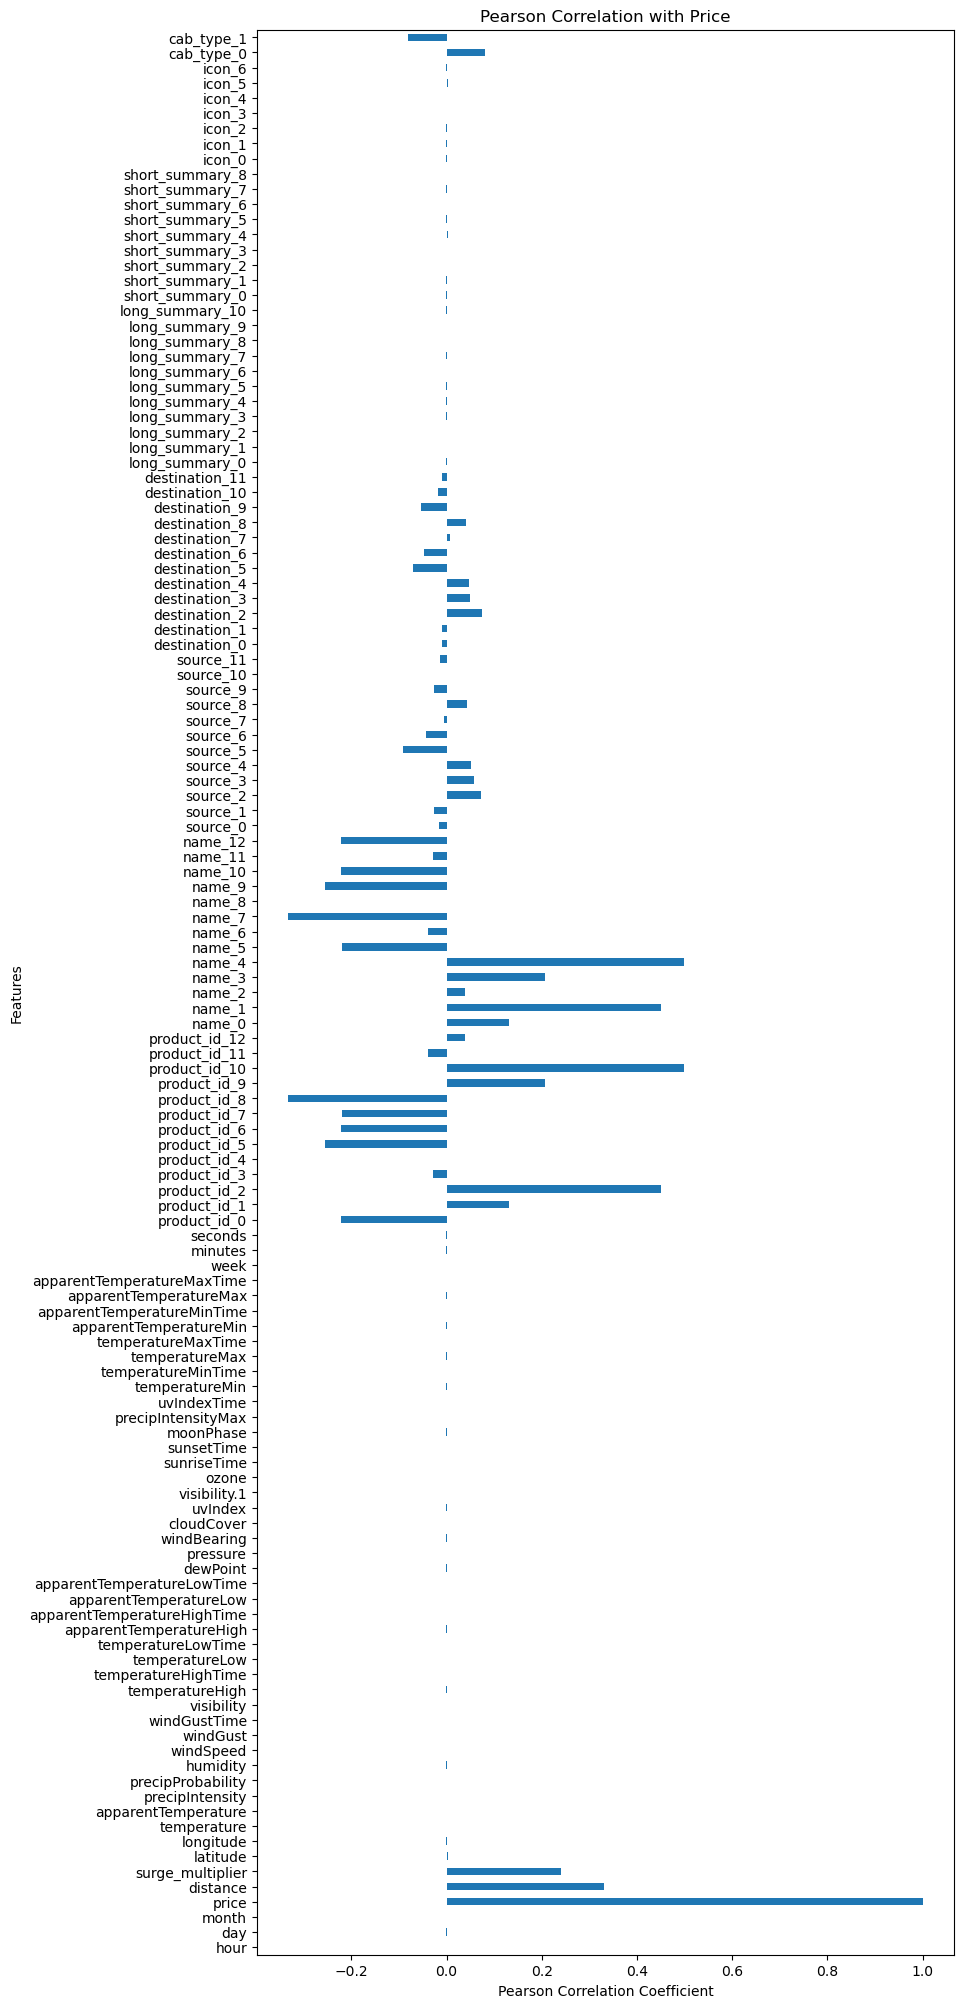

In [28]:
plt.figure(figsize=(9, 25))
df_model.corr(method='pearson')['price'].plot(kind='barh')

# Set the plot title and labels
plt.title('Pearson Correlation with Price')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Features')

# Display the plot
plt.show()

## Modeling

### Train Set & Test Set Split

In [29]:
X = df_model.drop('price', axis=1)
y = df_model['price']

In [30]:
scaler = StandardScaler()
scaler.fit(X)
X_std = scaler.transform(X)

print(X_std.shape)
print(y.shape)

(692025, 126)
(692025,)


In [31]:
# Split the data into train and test sets 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(553620, 126)
(553620,)
(138405, 126)
(138405,)


(None, None)

In [32]:
# Model
lr = LinearRegression()
dtr = DecisionTreeRegressor(random_state=33)
rfr = RandomForestRegressor(random_state=33)
abr = AdaBoostRegressor(random_state=33)
cbr = CatBoostRegressor(random_state=33)
xgbr = XGBRegressor(random_state=33)
lgbr = lgb.LGBMRegressor(random_state=33)

### Train Subset & Validation Split on Train Set

![Image Description](https://miro.medium.com/v2/resize:fit:828/format:webp/1*obKmc_bTKbUFgcgryhaAnA.png)

I did 3 split which are 80:10:10 (train subset, validation set & test set). Train, validation set are used for cross-validation and test set are used for final evaluation.
* Train set -> data to design model (in-sample data)
* Validation set -> data to refine model
* Testing set -> data to test model (out-of-sample data)

In [33]:
# Cross-validation using train sets (train and validation sets)
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def eval_crossval_models(X_train, y_train, models):
    scores = []
    scoring = {
        'R2': make_scorer(r2_score),
        'MAE': make_scorer(mean_absolute_error),
        'MSE': make_scorer(mean_squared_error),
        'RMSE': make_scorer(rmse)
    }

    for model_name, model in models:
        cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=True, n_jobs=-1)

        for metric in scoring.keys():
            for score_type in ['train', 'test']:
                scores.append({
                    'model': model_name,
                    'metric': metric,
                    'score_type': score_type,
                    'cv_score_1': cv_results[f'{score_type}_{metric}'][0],
                    'cv_score_2': cv_results[f'{score_type}_{metric}'][1],
                    'cv_score_3': cv_results[f'{score_type}_{metric}'][2],
                    'cv_score_4': cv_results[f'{score_type}_{metric}'][3],
                    'cv_score_5': cv_results[f'{score_type}_{metric}'][4],
                    'cv_mean': cv_results[f'{score_type}_{metric}'].mean(),
                    'cv_std': cv_results[f'{score_type}_{metric}'].std(),
                })

    print("Cross-Validation Results:")
    for score in scores:
        model_name = score['model']
        metric_name = score['metric']
        score_type = score['score_type']
        print(f"Model: {model_name}, Metric: {metric_name}, Score Type: {score_type}")
        for i in range(1, 6):
            print(f"Cross-Validation Score {i}: {score[f'cv_score_{i}']}")
        print(f"Mean Score: {score['cv_mean']:.4f}")
        print(f"Standard Deviation: {score['cv_std']:.4f}")
        print()

    df_metrics = pd.DataFrame(scores)

    return df_metrics

In [34]:
%%time
# Cross-validation using train sets (train and validation sets) for all models
models = [('Linear Regression', lr),
          ('Decision Trees', dtr),
          ('Random Forest', rfr),
          ('CatBoost', cbr),
          ('XGBoost', xgbr),
          ('LightGBM', lgbr)]

metric_results = eval_crossval_models(X_train, y_train, models)

/Users/agagoks/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/agagoks/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/agagoks/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/agagoks/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warn

Learning rate set to 0.107225
0:	learn: 8.2279519	total: 205ms	remaining: 3m 24s
1:	learn: 7.5934062	total: 354ms	remaining: 2m 56s
2:	learn: 7.0314177	total: 485ms	remaining: 2m 41s
3:	learn: 6.5463340	total: 633ms	remaining: 2m 37s
4:	learn: 6.1154327	total: 834ms	remaining: 2m 45s
5:	learn: 5.7265517	total: 1.02s	remaining: 2m 49s
6:	learn: 5.3878343	total: 1.19s	remaining: 2m 49s
7:	learn: 5.0842447	total: 1.32s	remaining: 2m 43s
8:	learn: 4.8144761	total: 1.49s	remaining: 2m 44s
9:	learn: 4.5676736	total: 1.7s	remaining: 2m 47s
10:	learn: 4.3506054	total: 1.87s	remaining: 2m 47s
11:	learn: 4.1598423	total: 2s	remaining: 2m 44s
12:	learn: 3.8985365	total: 2.16s	remaining: 2m 43s
13:	learn: 3.7401136	total: 2.29s	remaining: 2m 41s
14:	learn: 3.5236988	total: 2.47s	remaining: 2m 42s
15:	learn: 3.3398062	total: 2.65s	remaining: 2m 43s
16:	learn: 3.1965978	total: 2.78s	remaining: 2m 40s
17:	learn: 3.0820725	total: 2.92s	remaining: 2m 39s
18:	learn: 2.9478927	total: 3.04s	remaining: 2m 

Learning rate set to 0.107225
0:	learn: 8.2224065	total: 215ms	remaining: 3m 34s
1:	learn: 7.5878863	total: 441ms	remaining: 3m 40s
2:	learn: 7.0259003	total: 583ms	remaining: 3m 13s
3:	learn: 6.5404932	total: 866ms	remaining: 3m 35s
4:	learn: 6.1086340	total: 1.02s	remaining: 3m 23s
5:	learn: 5.7231023	total: 1.19s	remaining: 3m 17s
6:	learn: 5.3813111	total: 1.33s	remaining: 3m 8s
7:	learn: 5.0776690	total: 1.5s	remaining: 3m 5s
8:	learn: 4.8085089	total: 1.67s	remaining: 3m 3s
9:	learn: 4.5611595	total: 1.8s	remaining: 2m 58s
10:	learn: 4.3457095	total: 1.96s	remaining: 2m 56s
11:	learn: 4.1557215	total: 2.1s	remaining: 2m 53s
12:	learn: 3.8944641	total: 2.22s	remaining: 2m 48s
13:	learn: 3.7380978	total: 2.35s	remaining: 2m 45s
14:	learn: 3.5224376	total: 2.5s	remaining: 2m 44s
15:	learn: 3.3364021	total: 2.66s	remaining: 2m 43s
16:	learn: 3.1960054	total: 2.82s	remaining: 2m 43s
17:	learn: 3.0810821	total: 2.96s	remaining: 2m 41s
18:	learn: 2.9451333	total: 3.15s	remaining: 2m 42s

Learning rate set to 0.107225
0:	learn: 8.2235739	total: 198ms	remaining: 3m 17s
1:	learn: 7.5892415	total: 335ms	remaining: 2m 47s
2:	learn: 7.0294164	total: 456ms	remaining: 2m 31s
3:	learn: 6.5391017	total: 606ms	remaining: 2m 30s
4:	learn: 6.1122741	total: 847ms	remaining: 2m 48s
5:	learn: 5.7219911	total: 1.02s	remaining: 2m 48s
6:	learn: 5.3806660	total: 1.17s	remaining: 2m 46s
7:	learn: 5.0807535	total: 1.3s	remaining: 2m 41s
8:	learn: 4.8085479	total: 1.44s	remaining: 2m 38s
9:	learn: 4.5697599	total: 1.58s	remaining: 2m 36s
10:	learn: 4.3614980	total: 1.76s	remaining: 2m 37s
11:	learn: 4.1589905	total: 1.89s	remaining: 2m 35s
12:	learn: 3.8979885	total: 2.04s	remaining: 2m 34s
13:	learn: 3.7403509	total: 2.19s	remaining: 2m 34s
14:	learn: 3.6003768	total: 2.35s	remaining: 2m 34s
15:	learn: 3.3968753	total: 2.6s	remaining: 2m 40s
16:	learn: 3.2226820	total: 2.77s	remaining: 2m 39s
17:	learn: 3.0881414	total: 2.93s	remaining: 2m 40s
18:	learn: 2.9555026	total: 3.09s	remaining: 2

312:	learn: 1.6036355	total: 40.1s	remaining: 1m 27s
313:	learn: 1.6034753	total: 40.2s	remaining: 1m 27s
314:	learn: 1.6033236	total: 40.4s	remaining: 1m 27s
315:	learn: 1.6031560	total: 40.5s	remaining: 1m 27s
316:	learn: 1.6030480	total: 40.6s	remaining: 1m 27s
317:	learn: 1.6028760	total: 40.8s	remaining: 1m 27s
318:	learn: 1.6027133	total: 40.9s	remaining: 1m 27s
319:	learn: 1.6026420	total: 41s	remaining: 1m 27s
320:	learn: 1.6024743	total: 41.1s	remaining: 1m 27s
321:	learn: 1.6023331	total: 41.3s	remaining: 1m 26s
322:	learn: 1.6022491	total: 41.4s	remaining: 1m 26s
323:	learn: 1.6020854	total: 41.5s	remaining: 1m 26s
324:	learn: 1.6019766	total: 41.7s	remaining: 1m 26s
325:	learn: 1.6018855	total: 41.8s	remaining: 1m 26s
326:	learn: 1.6017265	total: 41.9s	remaining: 1m 26s
327:	learn: 1.6016283	total: 42s	remaining: 1m 26s
328:	learn: 1.6015500	total: 42.1s	remaining: 1m 25s
329:	learn: 1.6014534	total: 42.3s	remaining: 1m 25s
330:	learn: 1.6013258	total: 42.4s	remaining: 1m 2

312:	learn: 1.6024114	total: 40s	remaining: 1m 27s
313:	learn: 1.6022995	total: 40.1s	remaining: 1m 27s
314:	learn: 1.6021323	total: 40.2s	remaining: 1m 27s
315:	learn: 1.6019242	total: 40.4s	remaining: 1m 27s
316:	learn: 1.6017989	total: 40.5s	remaining: 1m 27s
317:	learn: 1.6015981	total: 40.6s	remaining: 1m 27s
318:	learn: 1.6014236	total: 40.7s	remaining: 1m 26s
319:	learn: 1.6012199	total: 40.9s	remaining: 1m 26s
320:	learn: 1.6011237	total: 41s	remaining: 1m 26s
321:	learn: 1.6008837	total: 41.1s	remaining: 1m 26s
322:	learn: 1.6007219	total: 41.2s	remaining: 1m 26s
323:	learn: 1.6005232	total: 41.4s	remaining: 1m 26s
324:	learn: 1.6004405	total: 41.5s	remaining: 1m 26s
325:	learn: 1.6003408	total: 41.6s	remaining: 1m 26s
326:	learn: 1.6001836	total: 41.7s	remaining: 1m 25s
327:	learn: 1.6000052	total: 41.9s	remaining: 1m 25s
328:	learn: 1.5998569	total: 42s	remaining: 1m 25s
329:	learn: 1.5997795	total: 42.1s	remaining: 1m 25s
330:	learn: 1.5997321	total: 42.2s	remaining: 1m 25s

312:	learn: 1.6111319	total: 40.2s	remaining: 1m 28s
313:	learn: 1.6110742	total: 40.4s	remaining: 1m 28s
314:	learn: 1.6109144	total: 40.5s	remaining: 1m 28s
315:	learn: 1.6108068	total: 40.7s	remaining: 1m 28s
316:	learn: 1.6105996	total: 40.8s	remaining: 1m 27s
317:	learn: 1.6104713	total: 41s	remaining: 1m 27s
318:	learn: 1.6104057	total: 41.1s	remaining: 1m 27s
319:	learn: 1.6102563	total: 41.2s	remaining: 1m 27s
320:	learn: 1.6100906	total: 41.3s	remaining: 1m 27s
321:	learn: 1.6099124	total: 41.4s	remaining: 1m 27s
322:	learn: 1.6097197	total: 41.5s	remaining: 1m 27s
323:	learn: 1.6095767	total: 41.7s	remaining: 1m 26s
324:	learn: 1.6094757	total: 41.8s	remaining: 1m 26s
325:	learn: 1.6091986	total: 41.9s	remaining: 1m 26s
326:	learn: 1.6091306	total: 42s	remaining: 1m 26s
327:	learn: 1.6089297	total: 42.1s	remaining: 1m 26s
328:	learn: 1.6087987	total: 42.3s	remaining: 1m 26s
329:	learn: 1.6085984	total: 42.4s	remaining: 1m 26s
330:	learn: 1.6085088	total: 42.6s	remaining: 1m 2

312:	learn: 1.5999677	total: 40.3s	remaining: 1m 28s
313:	learn: 1.5998859	total: 40.4s	remaining: 1m 28s
314:	learn: 1.5997322	total: 40.6s	remaining: 1m 28s
315:	learn: 1.5995862	total: 40.7s	remaining: 1m 28s
316:	learn: 1.5994087	total: 40.8s	remaining: 1m 27s
317:	learn: 1.5993333	total: 41s	remaining: 1m 27s
318:	learn: 1.5991636	total: 41.1s	remaining: 1m 27s
319:	learn: 1.5990143	total: 41.2s	remaining: 1m 27s
320:	learn: 1.5988963	total: 41.4s	remaining: 1m 27s
321:	learn: 1.5988190	total: 41.5s	remaining: 1m 27s
322:	learn: 1.5986743	total: 41.6s	remaining: 1m 27s
323:	learn: 1.5984763	total: 41.7s	remaining: 1m 27s
324:	learn: 1.5981922	total: 41.8s	remaining: 1m 26s
325:	learn: 1.5980025	total: 42s	remaining: 1m 26s
326:	learn: 1.5979242	total: 42.1s	remaining: 1m 26s
327:	learn: 1.5977486	total: 42.3s	remaining: 1m 26s
328:	learn: 1.5976230	total: 42.4s	remaining: 1m 26s
329:	learn: 1.5974530	total: 42.5s	remaining: 1m 26s
330:	learn: 1.5973816	total: 42.7s	remaining: 1m 2

/Users/agagoks/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/agagoks/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


623:	learn: 1.5689094	total: 1m 21s	remaining: 49.3s
624:	learn: 1.5688446	total: 1m 21s	remaining: 49.1s
625:	learn: 1.5687429	total: 1m 21s	remaining: 49s
626:	learn: 1.5686543	total: 1m 22s	remaining: 48.9s
627:	learn: 1.5685434	total: 1m 22s	remaining: 48.7s
628:	learn: 1.5684410	total: 1m 22s	remaining: 48.6s
629:	learn: 1.5683541	total: 1m 22s	remaining: 48.5s
630:	learn: 1.5682835	total: 1m 22s	remaining: 48.3s
631:	learn: 1.5682013	total: 1m 22s	remaining: 48.2s
632:	learn: 1.5681191	total: 1m 22s	remaining: 48.1s
633:	learn: 1.5680390	total: 1m 23s	remaining: 48s
634:	learn: 1.5678911	total: 1m 23s	remaining: 47.8s
635:	learn: 1.5678104	total: 1m 23s	remaining: 47.7s
636:	learn: 1.5677112	total: 1m 23s	remaining: 47.6s
637:	learn: 1.5675898	total: 1m 23s	remaining: 47.5s
638:	learn: 1.5675326	total: 1m 23s	remaining: 47.3s
639:	learn: 1.5674574	total: 1m 23s	remaining: 47.2s
640:	learn: 1.5674022	total: 1m 24s	remaining: 47.1s
641:	learn: 1.5672932	total: 1m 24s	remaining: 47s

793:	learn: 1.5557379	total: 1m 44s	remaining: 27.1s
794:	learn: 1.5556698	total: 1m 44s	remaining: 27s
795:	learn: 1.5556116	total: 1m 44s	remaining: 26.9s
796:	learn: 1.5555713	total: 1m 45s	remaining: 26.8s
797:	learn: 1.5555143	total: 1m 45s	remaining: 26.6s
798:	learn: 1.5554183	total: 1m 45s	remaining: 26.5s
799:	learn: 1.5553639	total: 1m 45s	remaining: 26.4s
800:	learn: 1.5552753	total: 1m 45s	remaining: 26.2s
801:	learn: 1.5551642	total: 1m 45s	remaining: 26.1s
802:	learn: 1.5550858	total: 1m 45s	remaining: 26s
803:	learn: 1.5550333	total: 1m 46s	remaining: 25.8s
804:	learn: 1.5549601	total: 1m 46s	remaining: 25.7s
805:	learn: 1.5548977	total: 1m 46s	remaining: 25.6s
806:	learn: 1.5548189	total: 1m 46s	remaining: 25.4s
807:	learn: 1.5547419	total: 1m 46s	remaining: 25.3s
808:	learn: 1.5546691	total: 1m 46s	remaining: 25.2s
809:	learn: 1.5545942	total: 1m 46s	remaining: 25.1s
810:	learn: 1.5544851	total: 1m 46s	remaining: 24.9s
811:	learn: 1.5544175	total: 1m 47s	remaining: 24.

623:	learn: 1.5743389	total: 1m 21s	remaining: 49.2s
624:	learn: 1.5742527	total: 1m 21s	remaining: 49.1s
625:	learn: 1.5741723	total: 1m 21s	remaining: 49s
626:	learn: 1.5740967	total: 1m 22s	remaining: 48.9s
627:	learn: 1.5740208	total: 1m 22s	remaining: 48.7s
628:	learn: 1.5738148	total: 1m 22s	remaining: 48.6s
629:	learn: 1.5737374	total: 1m 22s	remaining: 48.5s
630:	learn: 1.5736682	total: 1m 22s	remaining: 48.3s
631:	learn: 1.5736037	total: 1m 22s	remaining: 48.2s
632:	learn: 1.5735448	total: 1m 22s	remaining: 48.1s
633:	learn: 1.5734596	total: 1m 23s	remaining: 48s
634:	learn: 1.5733600	total: 1m 23s	remaining: 47.8s
635:	learn: 1.5732559	total: 1m 23s	remaining: 47.7s
636:	learn: 1.5731768	total: 1m 23s	remaining: 47.6s
637:	learn: 1.5731181	total: 1m 23s	remaining: 47.4s
638:	learn: 1.5730370	total: 1m 23s	remaining: 47.3s
639:	learn: 1.5729575	total: 1m 23s	remaining: 47.2s
640:	learn: 1.5728567	total: 1m 23s	remaining: 47s
641:	learn: 1.5727892	total: 1m 24s	remaining: 46.9s

Cross-Validation Results:
Model: Linear Regression, Metric: R2, Score Type: train
Cross-Validation Score 1: 0.919111614974744
Cross-Validation Score 2: 0.9187310991934716
Cross-Validation Score 3: 0.9190697072915033
Cross-Validation Score 4: 0.918573544574023
Cross-Validation Score 5: 0.9190766991037095
Mean Score: 0.9189
Standard Deviation: 0.0002

Model: Linear Regression, Metric: R2, Score Type: test
Cross-Validation Score 1: 0.9180805719885451
Cross-Validation Score 2: 0.9196042654026567
Cross-Validation Score 3: 0.9182545944429429
Cross-Validation Score 4: 0.9202390316740485
Cross-Validation Score 5: 0.9182218431800465
Mean Score: 0.9189
Standard Deviation: 0.0009

Model: Linear Regression, Metric: MAE, Score Type: train
Cross-Validation Score 1: 1.7949367599048867
Cross-Validation Score 2: 1.7975589476345049
Cross-Validation Score 3: 1.7931612377389698
Cross-Validation Score 4: 1.7984574558856257
Cross-Validation Score 5: 1.79478419312205
Mean Score: 1.7958
Standard Deviation: 0.

In [35]:
list_metric = ['RMSE', 'MSE', 'MAE', 'R2']
df_metrics = []
for select_metric in list_metric:
    if select_metric in metric_results.metric.values:
        df_temp = metric_results[metric_results['metric'] == select_metric].sort_values(by='score_type')
        df_metrics.append(df_temp)

df_metrics = pd.concat(df_metrics, ignore_index=True)

In [36]:
long_df_metrics = pd.melt(df_metrics, id_vars=['model', 'metric', 'score_type'], value_vars=[
                'cv_score_1', 'cv_score_2',
                'cv_score_3', 'cv_score_4', 'cv_score_5'])
sorted_long = long_df_metrics.sort_values(by=['metric','model','score_type','variable'])
sorted_long.head(5)

,model,metric,score_type,variable,value
27,CatBoost,MAE,test,cv_score_1,1.014568
75,CatBoost,MAE,test,cv_score_2,1.005326
123,CatBoost,MAE,test,cv_score_3,1.009768
171,CatBoost,MAE,test,cv_score_4,1.002673
219,CatBoost,MAE,test,cv_score_5,1.011563


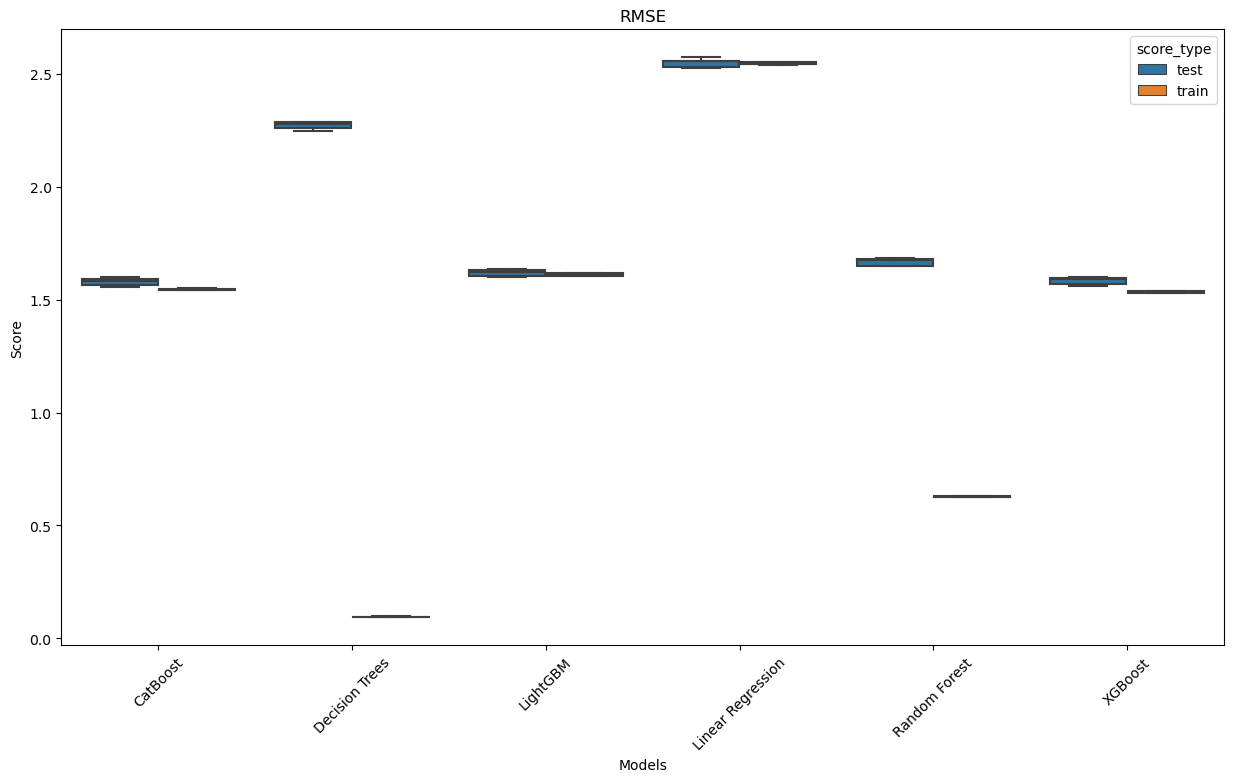

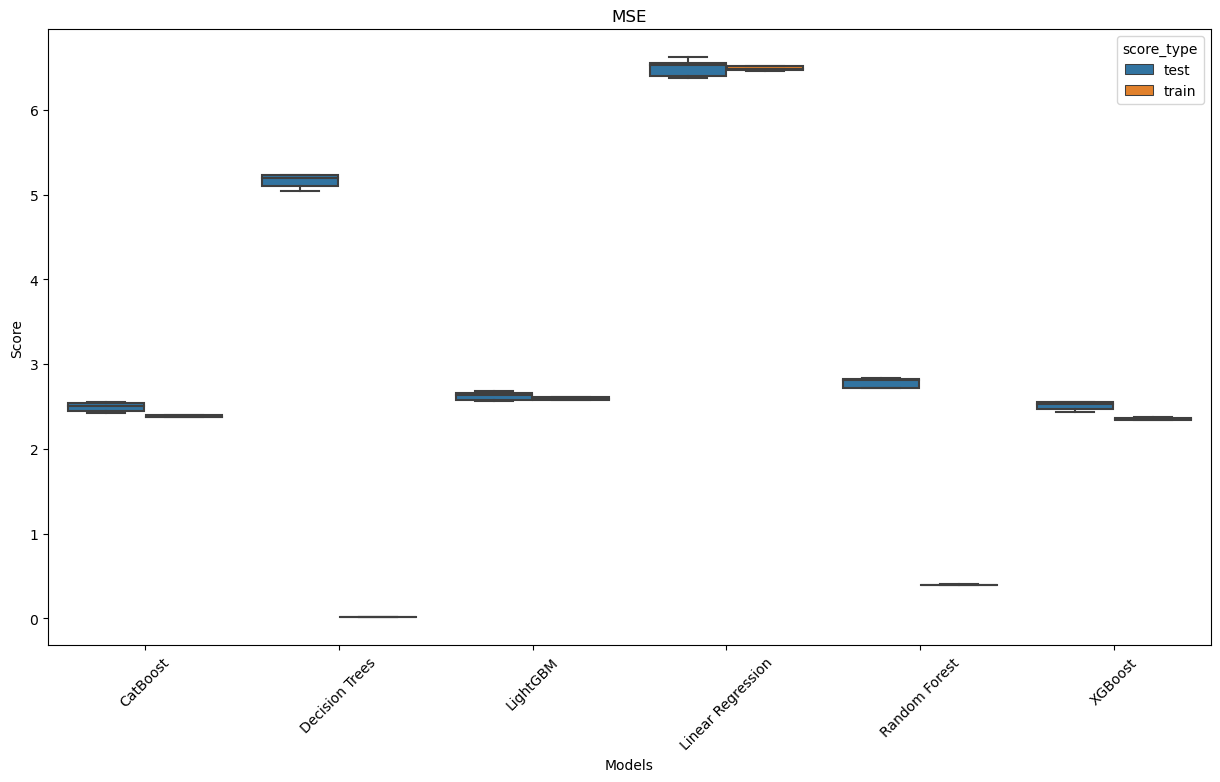

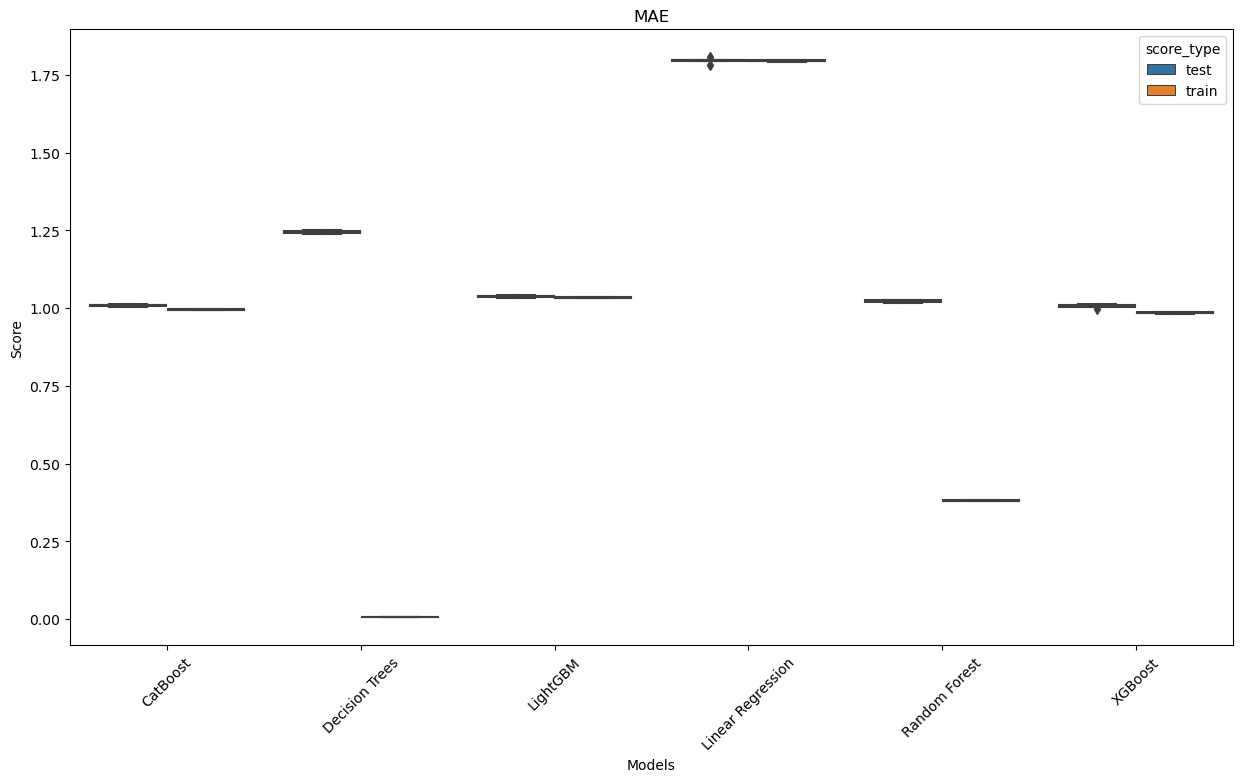

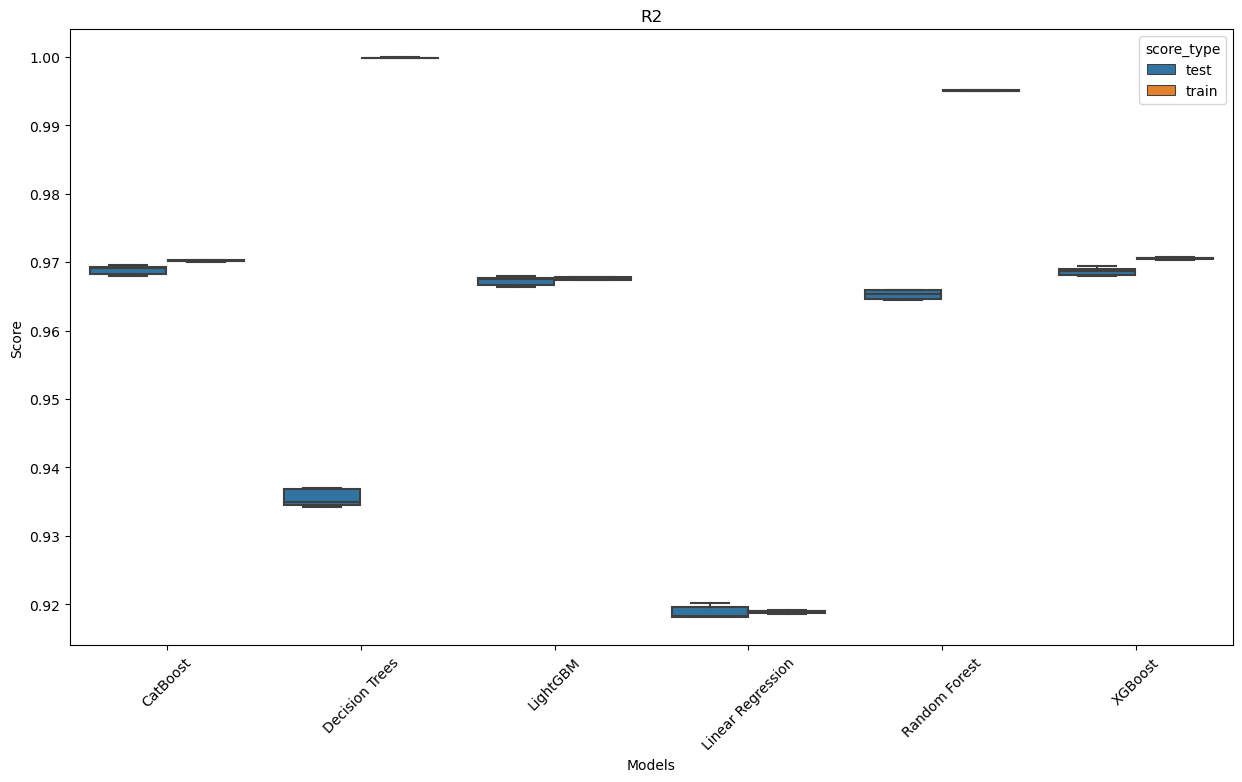

In [37]:
list_metric = ['RMSE', 'MSE', 'MAE', 'R2']
for select_metric in list_metric:
    df_select_metric = sorted_long[sorted_long['metric'] == select_metric]
    
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df_select_metric, x='model', y='value', hue='score_type')
    plt.title(select_metric)
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.xticks(rotation=45)

In cross-validation of train subset and validation set, from 6 models of machine learning that have learned, the LightGBM had the best performance among others based on their lowest of RMSE, MSE, MAE, highest R2 Score and lower ratio between train subset and validation (overfitting).

In [38]:
selected_lgbm = sorted_long[sorted_long['model']=='LightGBM'].groupby(['model','metric','score_type']).mean()
selected_lgbm

value
model    metric score_type          
LightGBM MAE    test        1.037420
                train       1.033931
         MSE    test        2.622168
                train       2.595258
         R2     test        0.967247
                train       0.967583
         RMSE   test        1.619243
                train       1.610973

## Tuning Model

### Halving Grid Search CV

num_leaves = 128
max_depth = 6
num_leaves <= 2 pangkat max_depth (x 55% ~ 63%)

In [39]:
(2**13)*0.63

5160.96

In [40]:
128*0.55

70.4

In [41]:
256+32

288

In [42]:
search_params = {
        "num_leaves" : [4505, 5160],
        "max_depth" : [13, 14],
        "min_data_in_leaf" : [150, 185, 220],
        "min_gain_in_leaf" : [6, 7, 8],
        "bagging_fraction" : [0.080, 0.085, 0.9],
        "feature_fraction" : [0.070, 0.075, 0.8],
        "reg_alpha" : [1.45, 1.6, 1.75],
        "reg_lambda" : [0.75, 0.85, 0.95],
        "learning_rate" : [0.0808, 0.0809, 0.081]
}

In [ ]:
%%time
warnings.filterwarnings("ignore")

# Create the HalvingGridSearchCV object instead of GridSearchCV because the data is large
grid_search = HalvingGridSearchCV(estimator=lgbr, param_grid=search_params,
                                  cv=5, scoring='neg_root_mean_squared_error',
                                  factor=2, n_jobs=-1)

# Fit the HalvingGridSearchCV object to the training data
grid_search.fit(X_train, y_train.values.ravel())

In [44]:
grid_search.cv_results_

{'iter': array([ 0,  0,  0, ..., 12, 13, 13]),
 'n_resources': array([    67,     67,     67, ..., 274432, 548864, 548864]),
 'mean_fit_time': array([2.65997887e-02, 2.70265579e-02, 2.22442627e-02, ...,
        2.01805531e+01, 4.33687143e+01, 3.29915851e+01]),
 'std_fit_time': array([4.52380168e-03, 6.38820656e-03, 2.69326197e-03, ...,
        1.05982134e+00, 5.78374211e-01, 1.32007766e+01]),
 'mean_score_time': array([2.07633972e-03, 2.34436989e-03, 1.99179649e-03, ...,
        2.09444699e+00, 5.67715645e+00, 4.76627502e+00]),
 'std_score_time': array([9.78397337e-04, 7.49012357e-04, 4.19446884e-04, ...,
        1.26405767e-01, 3.48077338e-01, 1.73064264e+00]),
 'param_bagging_fraction': masked_array(data=[0.08, 0.08, 0.08, ..., 0.08, 0.08, 0.08],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_feature_fraction': masked_array(data=[0.07, 0.07, 0.07, ..., 0.8, 0.8, 0.8],
              mask=[False, False, Fa

### Tuning Parameters

In [45]:
# Get the best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (RMSE):", -best_score)

Best Parameters: {'bagging_fraction': 0.08, 'feature_fraction': 0.8, 'learning_rate': 0.0808, 'max_depth': 14, 'min_data_in_leaf': 150, 'min_gain_in_leaf': 6, 'num_leaves': 5160, 'reg_alpha': 1.75, 'reg_lambda': 0.85}
Best Score (RMSE): 1.5897450763592318


In [46]:
# Train the final model with the best hyperparameters on the entire training set
final_model = lgb.LGBMRegressor(**best_params, random_state=33,
                                max_bin=350, metric='rmse', verbosity=0)
final_model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: min_gain_in_leaf
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.08, subsample=1.0 will be ignored. Current value: bagging_fraction=0.08
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

LGBMRegressor(bagging_fraction=0.08, feature_fraction=0.8, learning_rate=0.0808,
              max_bin=350, max_depth=14, metric='rmse', min_data_in_leaf=150,
              min_gain_in_leaf=6, num_leaves=5160, random_state=33,
              reg_alpha=1.75, reg_lambda=0.85, verbosity=0)

In [47]:
# Predict the labels of the test set
y_pred_train_final = final_model.predict(X_train)
y_pred_test_final = final_model.predict(X_test)

In [48]:
# Calculate evaluation metrics for the training set
r2_train_final = r2_score(y_train, y_pred_train_final)
mae_train_final = mean_absolute_error(y_train, y_pred_train_final)
mse_train_final = mean_squared_error(y_train, y_pred_train_final)
rmse_train_final = np.sqrt(mean_squared_error(y_train, y_pred_train_final))

# Calculate evaluation metrics for the test set
r2_test_final = r2_score(y_test, y_pred_test_final)
mae_test_final = mean_absolute_error(y_test, y_pred_test_final)
mse_test_final = mean_squared_error(y_test, y_pred_test_final)
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_pred_test_final))

In [49]:
# Print the evaluation metrics for both training and test sets
print("Training set:")
print(f"R^2: {r2_train_final:.3f}")
print(f"MAE: {mae_train_final:.3f}")
print(f"MSE: {mse_train_final:.3f}")
print(f"RMSE: {rmse_train_final:.3f}")

print("\nTest set:")
print(f"R^2: {r2_test_final:.3f}")
print(f"MAE: {mae_test_final:.3f}")
print(f"MSE: {mse_test_final:.3f}")
print(f"RMSE: {rmse_test_final:.3f}")

print(f"Overfit ratio: {mse_test_final/mse_train_final:.3f}")

Training set:
R^2: 0.971
MAE: 0.949
MSE: 2.312
RMSE: 1.520

Test set:
R^2: 0.968
MAE: 0.992
MSE: 2.576
RMSE: 1.605
Overfit ratio: 1.115


# Conclusion

The performance model of LightGBM has improved 0.865% based on RMSE test from 1.619 to 1.605 after did several hyperparameter tuning using HalvingGridSearchCV which indicates the model's predictions closely align with the actual fare prices, making it highly reliable for estimating fares for future rides.
